In [1]:
#INSTALL DEPENDENCIES
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
#IMPORT DEPENDENCIES
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#SETUP DEPENDENCIES
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#SETUP GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    

In [5]:
len(gpus)

0

In [6]:
#CREATE FOLDERS
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [10]:
#ADD NEGATIVE IMAGES
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [7]:
import uuid

In [58]:
#ESTABLISH A CONNETION TO THE WEBCAM
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[100:100+250,200:200+250,:]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

In [8]:
plt.imshow(frame[:,:,:])

NameError: name 'frame' is not defined

In [61]:
#Load and Preprocess Images

In [9]:
#Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
dir_test.next()

b'data\\anchor\\33544ede-20a2-11ee-b6c7-004238ccdd40.jpg'

In [12]:
#Preprocessing - Scale and Resize
def preprocess(file_path):
    
    #Reading the image from file path
    byte_img = tf.io.read_file(file_path)
    #loading the image
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing steps - resizing the image to 100x100x3
    img = tf.image.resize(img,(100,100))
    #scale image to be between 0 and 1
    img = img/255.0
    return img

In [13]:
img = preprocess('data\\anchor\\32aa29cc-20a3-11ee-a327-004238ccdd40.jpg')

In [14]:
img.numpy().max()

0.9286765

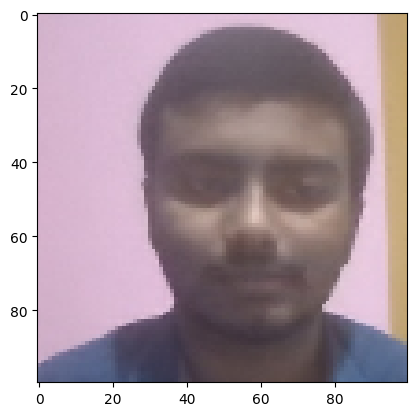

In [15]:
plt.imshow(img)

In [18]:
# dataset.map(preprocess)

In [74]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
example

(b'data\\anchor\\2d795e90-20a2-11ee-943b-004238ccdd40.jpg',
 b'data\\positive\\c242749c-20a3-11ee-8d65-004238ccdd40.jpg',
 1.0)

In [20]:
#Build Train and Test Partition

def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*example)

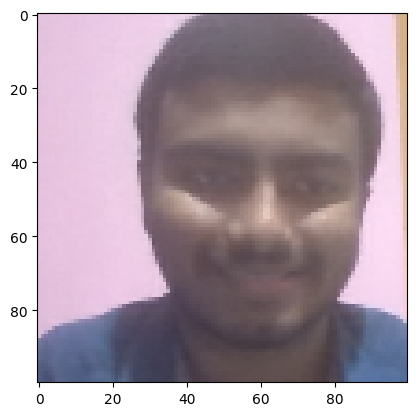

In [22]:
plt.imshow(res[1])

In [23]:
res[2]

1.0

In [24]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
#Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
#Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [1]:
#Build Embedding Layer

In [27]:
inp = Input(shape=(105,105,3),name='input_image')

In [28]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [29]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)
m1 = MaxPooling2D(64,(2,2),padding='same')(c1) #padding='same' is discovered while coding

In [30]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [31]:
c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

In [33]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [32]:
c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

In [34]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [35]:
c4 = Conv2D(256,(4,4),activation = 'relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [36]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [37]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    #First block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1) #padding='same' is discovered while coding
    
    #Second block
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    #Final embedding block
    c4 = Conv2D(256,(4,4),activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [64]:
#Build distance layer

In [40]:
class L1Dist(Layer):
    #Inheriting layer
    def __init__(self, **kwargs):
        super().__init__()
    
    #similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()

In [42]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [43]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [44]:
def make_siamese_model():
    
    #anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [45]:
siamese_model = make_siamese_model()

In [46]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [ ]:
#Training

In [ ]:
#Setup loss and Optimizer

In [47]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [49]:
opt = tf.keras.optimizers.Adam(1e-4) #0.001

In [50]:
#Establish Check points

In [52]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
# print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [53]:
test_batch = train_data.as_numpy_iterator()

In [54]:
batch_1 = test_batch.next()

In [65]:
X = batch_1[:2]
print(X)

(array([[[[0.84705883, 0.72156864, 0.8156863 ],
         [0.8480392 , 0.7245098 , 0.8186275 ],
         [0.8382353 , 0.7205882 , 0.8147059 ],
         ...,
         [0.7754902 , 0.654902  , 0.46764705],
         [0.77254903, 0.654902  , 0.45294118],
         [0.7737745 , 0.65612745, 0.4522059 ]],

        [[0.84607846, 0.7205882 , 0.8147059 ],
         [0.845098  , 0.72156864, 0.8156863 ],
         [0.84313726, 0.7254902 , 0.81960785],
         ...,
         [0.7732843 , 0.6517157 , 0.46740195],
         [0.7747549 , 0.65686274, 0.4615196 ],
         [0.7747549 , 0.65710783, 0.45318627]],

        [[0.84705883, 0.72156864, 0.8156863 ],
         [0.84583336, 0.7223039 , 0.81642157],
         [0.842402  , 0.7247549 , 0.8188726 ],
         ...,
         [0.77843136, 0.65686274, 0.47549018],
         [0.7703431 , 0.6517157 , 0.45857844],
         [0.77254903, 0.654902  , 0.4509804 ]],

        ...,

        [[0.40416667, 0.4237745 , 0.57279414],
         [0.39828432, 0.42083332, 0.5688726 

In [60]:
y = batch_1[2]

In [61]:
y

array([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

In [66]:
#Build Train Step Function
@tf.function
def train_step(batch):
    
    #Record all of our operations
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get label
        y = batch[2]
        
        #Forward pass
        yhat = siamese_model(X, training=True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)  
    
    #Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #Return loss
    return loss

In [67]:
#Build training loop

def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
    

In [68]:
EPOCHS = 50

In [69]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1544s 57s/step

 Epoch 2/50
27/27 [==============================] - 1543s 57s/step

 Epoch 3/50
27/27 [==============================] - 1536s 57s/step

 Epoch 4/50
27/27 [==============================] - 1512s 56s/step

 Epoch 5/50
27/27 [==============================] - 840s 30s/step

 Epoch 6/50
27/27 [==============================] - 695s 26s/step

 Epoch 7/50
27/27 [==============================] - 706s 26s/step

 Epoch 8/50
27/27 [==============================] - 703s 26s/step

 Epoch 9/50
27/27 [==============================] - 698s 26s/step

 Epoch 10/50
27/27 [==============================] - 699s 26s/step

 Epoch 11/50
27/27 [==============================] - 710s 26s/step

 Epoch 12/50
27/27 [==============================] - 703s 26s/step

 Epoch 13/50
27/27 [==

In [70]:
#Evaluate Model
#Import metric calculations
from tensorflow.keras.metrics import Precision,Recall


In [71]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [77]:
#Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat 

array([[2.2861995e-19],
       [9.9924958e-01],
       [9.8546743e-01],
       [3.4105603e-20],
       [1.1557303e-17],
       [7.4910103e-20],
       [8.7559092e-01],
       [9.9452746e-01],
       [1.8462144e-13],
       [9.8060668e-01],
       [9.8956072e-01],
       [9.9743551e-01],
       [9.9961233e-01],
       [9.8528731e-01],
       [1.3940141e-08],
       [1.5957862e-20]], dtype=float32)

In [78]:
#Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]

In [79]:
y_true

array([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [81]:
#Creating a metric object
m = Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()

1.0

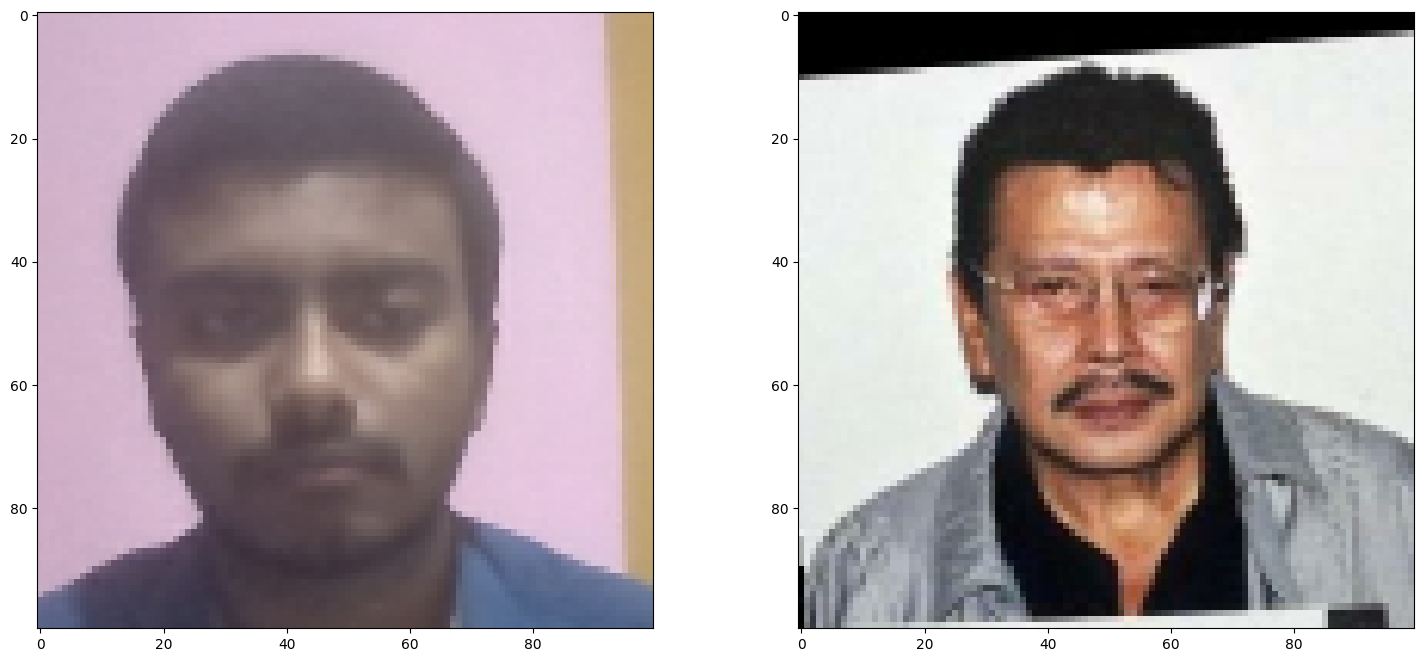

In [87]:
#Viz Results

#Set plot size
plt.figure(figsize=(18,8))

#Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

#Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

#Show plot
plt.show()

In [88]:
#Save Model

#Save weights
siamese_model.save('siamesemodel.h5')

In [89]:
#Reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [92]:
tf.keras.models.load_model??

In [93]:
#make predictions with a reloaded model
model.predict([test_input, test_val])

array([[2.2861995e-19],
       [9.9924958e-01],
       [9.8546743e-01],
       [3.4105603e-20],
       [1.1557303e-17],
       [7.4910103e-20],
       [8.7559092e-01],
       [9.9452746e-01],
       [1.8462144e-13],
       [9.8060668e-01],
       [9.8956072e-01],
       [9.9743551e-01],
       [9.9961233e-01],
       [9.8528731e-01],
       [1.3940141e-08],
       [1.5957862e-20]], dtype=float32)

In [95]:
#view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [96]:
#Real Time Test

In [102]:
#Verification Function
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        
        #Make predictions
        result = model.predict(list(np.expand_dims([input_img,validation_img], axis=1)))
        results.append(result)
      
    #Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    #Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
        
    return results, verified
    

In [106]:
#OpenCV Real Time Verification

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[100:100+250,200:200+250,:]
    
    cv2.imshow('Verification', frame)
    
    #Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False
False
False
True
True
True


In [107]:
# succedded !!!!